In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.power import TTestIndPower
# dataset source - https://www.kaggle.com/datasets/adarsh0806/ab-testing-practice

In [2]:
# loading in the dataset and viewing the first few rows
df = pd.read_csv('ab_testing.csv')
df.head()

,User ID,Group,Page Views,Time Spent,Conversion,Device,Location
0,14292,B,3,424,No,Mobile,Northern Ireland
1,11682,A,9,342,No,Mobile,Scotland
2,19825,A,2,396,No,Desktop,Northern Ireland
3,16080,B,4,318,No,Desktop,Wales
4,18851,A,1,338,Yes,Desktop,Scotland


- Group A is the control group who used the orignal website version.
- Group B is the treatment group who used the new version of the website.

# EDA

In [3]:
# checking for any duplicate rows
df.duplicated().sum()

0

In [4]:
# Checking df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   User ID     5000 non-null   int64 
 1   Group       5000 non-null   object
 2   Page Views  5000 non-null   int64 
 3   Time Spent  5000 non-null   int64 
 4   Conversion  5000 non-null   object
 5   Device      5000 non-null   object
 6   Location    5000 non-null   object
dtypes: int64(3), object(4)
memory usage: 273.6+ KB


# Group 

In [5]:
# Checking the number of people for each group
df.Group.value_counts()

Group
A    2519
B    2481
Name: count, dtype: int64

# Page Views

In [6]:
# Checking the spread of page views
df['Page Views'].describe()

count    5000.000000
mean        7.537600
std         4.022465
min         1.000000
25%         4.000000
50%         8.000000
75%        11.000000
max        14.000000
Name: Page Views, dtype: float64

# Time Spent

In [7]:
# Checking the spread of time spent
df['Time Spent'].describe()

count    5000.000000
mean      242.512600
std       118.254153
min        40.000000
25%       137.000000
50%       243.000000
75%       346.000000
max       449.000000
Name: Time Spent, dtype: float64

# Conversion

In [8]:
# Checking the number of people who were and were not converted
df.Conversion.value_counts()

Conversion
No     4515
Yes     485
Name: count, dtype: int64

In [9]:
# Changing the values to be numeric values instead of categorical
df.Conversion = df.Conversion.map({'Yes':1, 'No':0})

# Device

In [10]:
# Checking the number of people who used different devices
df.Device.value_counts()

Device
Desktop    2538
Mobile     2462
Name: count, dtype: int64

# Location

In [11]:
# Checking the number of people from different locations
df.Location.value_counts()

Location
Scotland            1281
England             1246
Northern Ireland    1242
Wales               1231
Name: count, dtype: int64

# A&B Testing

# Sample Size - Proportions - Chi-Squared & Z-Test

In [12]:
# Define parameters
alpha = 0.05  # Significance level (5%)
power = 0.9   # Desired power (90%)
effect_size = proportion_effectsize(df[df['Group']=='A']['Conversion'].mean(),
                                   df[df['Group']=='B']['Conversion'].mean())  # Compute Cohen’s h

In [13]:
# Calculate required sample size per group
analysis = NormalIndPower()
sample_size_proportions = analysis.solve_power(effect_size, power=power, alpha=alpha, ratio=1, alternative='two-sided')

print(f"Required sample size per group: {int(np.ceil(sample_size_proportions))}")

Required sample size per group: 234


- From the power analysis a size of 234 people for each group is required to detect the given effect size. As both group have more than enough samples, the results from the chi-squared and z-test of proportions will be reliable.

# Chi-Squared

# Chi-Squared Test Assumptions

- 1.The observations should be independently randomly sampled from the population.
- 2.The categories of both variables must be mutually exclusive.
- 3.All samples should be from distinct users.

# Chi-Squared Test - Conversion Rates Test

- Null Hypothesis: There is no association between the group (A or B) and conversion (Yes or No). In other words, the             conversion rate is the same for both groups. 
- Alternative Hypothesis: There is an association between the group and conversion. That is, conversion rates differ between Group A and Group B.
- Significance threshold of 0.05

# Checking Chi-Squared Test Assumptions

- 1.The dataset is created from random synthetic samples. Therefore each person is independent and has no influence on another      persons decision to convert or not.
- 2.The categories of both variables are mutually exclusive. Each person is only part of one group and only has one value in the conversion column. (yes or no)
- 3.Each sample in the test has their own unique user id. After checking for any duplicates none were found, meaning all rows are distinct.

# Implementing Chi-Squared Test - Conversion Rates

In [14]:
# Getting the conversion rates for both groups
conversion_rates = df.groupby('Group')['Conversion'].mean()
conversion_rates

Group
A    0.053990
B    0.140669
Name: Conversion, dtype: float64

In [15]:
# Creating a crosstab table of the group and conversion columns
table = pd.crosstab(df.Group, df.Conversion)
table

Conversion,0,1
Group,,
A,2383,136
B,2132,349


In [16]:
# Running a chi squared test 
chi2, pval, dof, expected = chi2_contingency(table)
print(chi2)
print(pval)

if pval < 0.05:
    print("Statistically significant difference in conversion rates between groups.")
else:
    print("No statistically significant difference in conversion rates.")

106.22812337440538
6.571736018334222e-25
Statistically significant difference in conversion rates between groups.


# Z-Test Of Proportions

# Z-Test Of Proportions Assumptions

- 1.Independent observations.
- 2.Random assignment of groups.
- 3.Large enough sample size.
- 4.Stationarity.

# Z-Test Of Proportion - Conversion Rates

- Null Hypothesis: There is no association between the group (A or B) and conversion (Yes or No). In other words, the conversion rate is the same for both groups.
- Alternative Hypothesis: There is an association between the group and conversion. That is, conversion rates differ between Group A and Group B.
- Significance threshold of 0.05

# Checking Z-Test Of Proportions Assumptions

- 1.The dataset is created from random synthetic samples. Therefore each person is independent and has no influence on another persons decision to convert or not.
- 2.Again the dataset is created from random synthetic samples so therefore random assignment. Also groups are balanced with 2519 in group A and 2481 in group B. Also groups are evenly split in device and location aswell.
- 3.As Z-test relies on a normal distribution approximation of the binomial distribution the rule of thumb is each group has at least 5 success and 5 failures which the dataset has.
- 4.Data was synthetically created so data is over a stable period of time and consistent. No outlier period like black friday sale on the website.

# Implementing Z-Test Of Proportions

In [17]:
# Isolating the conversion column for group a & b
group_a_conv_col = df[df['Group']=='A']['Conversion']
group_b_conv_col = df[df['Group']=='B']['Conversion']

In [18]:
# Calculating the conversion rate for both groups
group_a_conv_rate = group_a_conv_col.mean()
group_b_conv_rate = group_b_conv_col.mean()

In [19]:
# Getting the total number of people in each group
samples_A = len(group_a_conv_col)
samples_B = len(group_b_conv_col)

In [20]:
# Getting the number of conversions for each group
conversions_A = group_a_conv_col.sum()
conversions_B = group_b_conv_col.sum()

In [21]:
# Computing the standard error
pooled_conv = (conversions_A + conversions_B) / (samples_A + samples_B)

standard_error = np.sqrt(pooled_conv * (1 - pooled_conv) * (1/samples_A + 1/samples_B))

In [22]:
# Implementing Z-Test
z_score = (group_a_conv_rate - group_b_conv_rate) / standard_error

p_value = sm.stats.proportions_ztest([conversions_B, conversions_A], [samples_B, samples_B], alternative='larger')[1]
print(f"Z-score: {z_score}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Statistically significant difference in conversion rates between groups.")
else:
    print("No statistically significant difference in conversion rates.")

Z-score: -10.354488520266216
P-value: 1.190023050071594e-24
Statistically significant difference in conversion rates between groups.


# Chi-Squared & Z-Test Of Proportions - Effect Size 

In [23]:
# Creating a function to calculate the effect size between the two groups of proportions
def cohen_h(p1, p2):
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

In [24]:
# Using the conversion rates of both groups in the function
effect_size_conv = abs(cohen_h(group_a_conv_rate, group_b_conv_rate))
print(f"Cohen's h: {effect_size_conv:.4f}")

Cohen's h: 0.2999


- A cohen's h of 0.2999 is in between the small and medium effect size groups. So even though the I have gotten statistically significant results from my tests, it may not have any meaningful impact for the business if they change to website B. To be more confident in the A&B tests the effect size would preferably be above 0.5.

# Chi-Squared & Z-Test Of Proportions - Actual Power

In [25]:
# Computing the actual power with group a sample size
actual_power_z_test = analysis.power(effect_size_conv, nobs1=samples_A, alpha=0.05, ratio=samples_B/samples_A)
print(f"Actual power of the test: {actual_power_z_test:.4f}")

Actual power of the test: 1.0000


- Due to having much more data than the required the sample size suggested the power of the test is perfect.

# Bayesian A&B Testing

# Bayesian A&B Test Assumptions

- 1. Independent Observations
- 2. Random assignment of groups
- 3. Correct prior selection
- 4. Sufficient sample size
- 5. Stationarity
- 6. Appropriate likelihood model

# Checking Bayesian A&B Test Assumptions

- 1. The dataset is created from random synthetic samples. Therefore each person is independent and has no influence on another persons decision to convert or not.
- 2. Again the dataset is created from random synthetic samples so therefore random assignment. Also groups are balanced with 2519 in group A and 2481 in group B.
- 3. Due to not having any initial assumption on baseline conversion I chose a uninformative prior of Beta(1,1), to avoid biasing any results.
- 4. From bayesian power analysis below we can see that a minimum of 700 people are required for each group to pass the threshold of 95% that group B is better than group A.
- 5. Data was synthetically created so data is over a stable period of time and consistent. No outlier period like black friday sale on the website.
- 6. As the outcome variable conversion is binary I will use the Beta-Binomial Model.

Sufficient sample size found: 600 per group


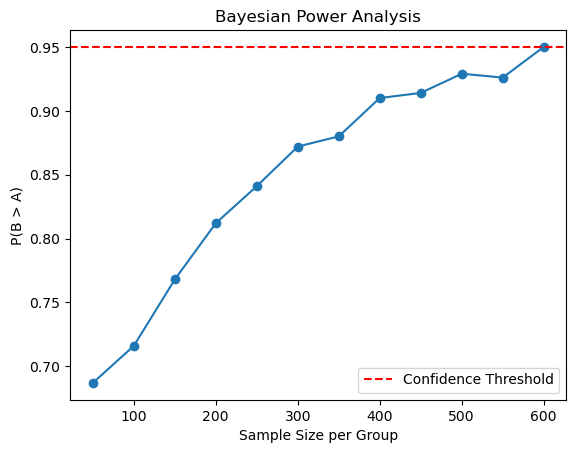

In [26]:
# Assumption 4 - Checking for sufficient sample size
# Function to simulate Bayesian power analysis
def bayesian_power_analysis(p_A=0.05, uplift=0.03, confidence_threshold=0.95, max_sample_size=5000, step=50, num_simulations=1000):
    
    # Expected conversion rate for Group B
    p_B = p_A + uplift 
    # Getting the jumps in sample sizes to check
    sample_sizes = np.arange(step, max_sample_size + step, step)
    probabilities = []

    for N in sample_sizes:
        successes_A = np.random.binomial(N, p_A, num_simulations)
        successes_B = np.random.binomial(N, p_B, num_simulations)

        # Posterior distribution (Beta priors with weak prior belief)
        posterior_A = np.random.beta(successes_A + 1, N - successes_A + 1, num_simulations)
        posterior_B = np.random.beta(successes_B + 1, N - successes_B + 1, num_simulations)

        # Probability that B is better than A
        prob_B_superior = np.mean(posterior_B > posterior_A)
        probabilities.append(prob_B_superior)

        if prob_B_superior >= confidence_threshold:
            print(f"Sufficient sample size found: {N} per group")
            break

    # Plot results
    plt.plot(sample_sizes[:len(probabilities)], probabilities, marker='o', linestyle='-')
    plt.axhline(y=confidence_threshold, color='r', linestyle='--', label="Confidence Threshold")
    plt.xlabel("Sample Size per Group")
    plt.ylabel("P(B > A)")
    plt.title("Bayesian Power Analysis")
    plt.legend()
    plt.show()

# Run Bayesian power analysis
bayesian_power_analysis()

# Implementing Bayesian A&B Test

In [27]:
# Count successes and trials for each group
conversion_counts = df.groupby('Group')['Conversion'].sum()
sample_sizes = df.groupby('Group')['Conversion'].count()

In [28]:
# Extract values for Bayesian calculations. Number of conversions/samples in each group
conversions_A = conversion_counts['A']
conversions_B = conversion_counts['B']
samples_A = sample_sizes['A']
samples_B = sample_sizes['B']

print(f"Group A: {conversions_A}/{samples_A} converted")
print(f"Group B: {conversions_B}/{samples_B} converted")

Group A: 136/2519 converted
Group B: 349/2481 converted


In [29]:
# Define prior hyperparameters
alpha_prior = 1  # Prior conversions (successes)
beta_prior = 1   # Prior non-conversions (failures)

In [30]:
# Calculating posterior distributions
alpha_A = alpha_prior + conversions_A
beta_A = beta_prior + (samples_A - conversions_A)
alpha_B = alpha_prior + conversions_B
beta_B = beta_prior + (samples_B - conversions_B)

In [31]:
# Sample from the posterior distributions
np.random.seed(42)
samples_a = np.random.beta(alpha_A, beta_A, 100000)
samples_b = np.random.beta(alpha_B, beta_B, 100000)

In [32]:
# Getting the probability that group b had the better website
prob_B_better = np.mean(samples_b > samples_a)
print(f"Probability that B is better than A: {prob_B_better:.4f}")

Probability that B is better than A: 1.0000


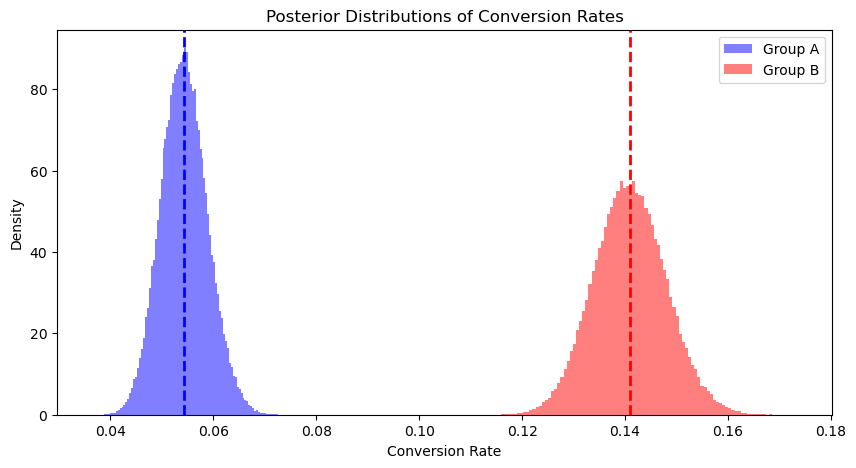

In [33]:
# Visualising the posterior distributions
plt.figure(figsize=(10,5))
plt.hist(samples_a, bins=100, alpha=0.5, label="Group A", color='blue', density=True)
plt.hist(samples_b, bins=100, alpha=0.5, label="Group B", color='red', density=True)
plt.axvline(np.mean(samples_a), color='blue', linestyle='dashed', linewidth=2)
plt.axvline(np.mean(samples_b), color='red', linestyle='dashed', linewidth=2)
plt.legend()
plt.title("Posterior Distributions of Conversion Rates")
plt.xlabel("Conversion Rate")
plt.ylabel("Density")
plt.show()

# Two Sample T-Tests

# Assumptions For Two Sample T-Test

- 1.The observations should be independently randomly sampled from the population.
- 2.The standard deviations of the groups should be equal.
- 3.The data should be normally distributed…ish.
- 4.The groups created by the categorical variable must be independent.

# Two Sample T-Test - Page Views

- Null Hypothesis: The mean number of page views is the same for both groups. Any observed difference is due to random chance.
- Alternative Hypothesis: The mean number of page views is different between Group A and Group B. It is not down to random chance.
- Significance Threshold: 0.05

# Sample Size - Continuous - Page Views

In [34]:
# Creating a function to calculate the effect size between the two continuous groups
def cohen_d(x1, x2):
    mean_diff = np.mean(x1) - np.mean(x2)
    pooled_std = np.sqrt((np.std(x1, ddof=1) ** 2 + np.std(x2, ddof=1) ** 2) / 2)
    return mean_diff / pooled_std

In [35]:
# Compute Cohen's d - effect size of page view groups
effect_size_page_views = cohen_d(df[df['Group']=='A']['Page Views'] , df[df['Group']=='B']['Page Views'])

In [36]:
# Calculate required sample size per group
analysis = TTestIndPower()
sample_size_page_views = analysis.solve_power(effect_size_page_views, power=0.8, alpha=0.05)

print(f"Required sample size per group for page views test: {int(np.ceil(sample_size_page_views))}")

Required sample size per group for page views test: 32328


- The required sample size to detect the effect size is much larger than this dataset. Therefore if I get a significant result it will not be reliable enough to detect real effects.

# Checking Two Sample T-Test Assumptions

- 1.The dataset is created from random synthetic samples. Therefore each person is independent and has no influence on another     persons decision to view multiple pages.

In [37]:
# 2. Calculating and comparing the stds of group a/b for page views
group_a_b_std_page_views = np.std(df[df['Group']=='A']['Page Views']) / np.std(df[df['Group']=='B']['Page Views'])
print(group_a_b_std_page_views)
# Value is between the range of 0.9 - 1.1.

1.0294263640915635


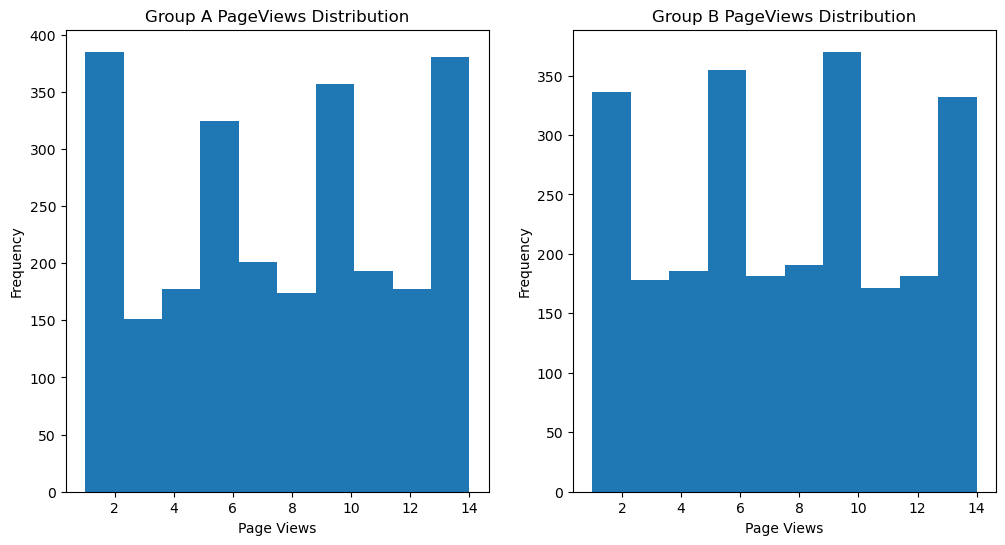

In [38]:
# 3. Checking the distribution of page views for both groups
# Creating two dfs for each of the groups
group_a = df[df['Group']=='A']
group_b = df[df['Group']=='B']

# Visualising the distribution of page views for both groups
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(group_a['Page Views'])
plt.title('Group A PageViews Distribution')
plt.xlabel('Page Views')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(group_b['Page Views'])
plt.title('Group B PageViews Distribution')
plt.xlabel('Page Views')
plt.ylabel('Frequency')
plt.show()

# We can see that the pageviews is not normally distributed. But we can check to see if the sampling distribution of the means is. 

In [39]:
# Calculating the sampling distribution of the means for group a/b pageviews
sample_size = 30
num_samples = 1000
group_a_sample_means = []
group_b_sample_means = []

# Creating a random sample of pageviews from both group a and group b. Then calculating the mean and adding it to the list.
for _ in range(num_samples):
    sample = np.random.choice(group_a['Page Views'], size=sample_size, replace=True)
    sample_mean = np.mean(sample)
    group_a_sample_means.append(sample_mean)

for _ in range(num_samples):
    sample = np.random.choice(group_b['Page Views'], size=sample_size, replace=True)
    sample_mean = np.mean(sample)
    group_b_sample_means.append(sample_mean)

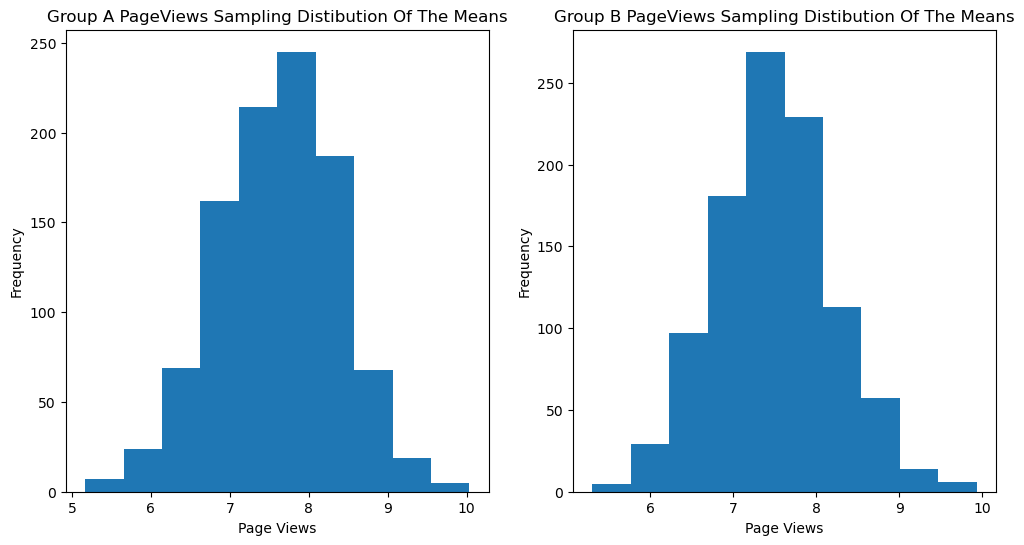

In [40]:
# Visualising the sampling distibution of the means for group a/b pageviews
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(group_a_sample_means)
plt.title('Group A PageViews Sampling Distibution Of The Means')
plt.xlabel('Page Views')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(group_b_sample_means)
plt.title('Group B PageViews Sampling Distibution Of The Means')
plt.xlabel('Page Views')
plt.ylabel('Frequency')
plt.show()

- 4.Group A and Group B are independent from one another and a person from each one cannot influence another.

# Implementing Two Sample T-Test - Page Views

In [41]:
# Running a two sample t-test for page views
tstat_pageviews, pval_pageviews = ttest_ind(group_a['Page Views'], group_b['Page Views'], equal_var=False)
print(tstat_pageviews)
print(pval_pageviews)

if pval_pageviews < 0.05:
    print("Significant difference in page views between groups.")
else:
    print("No significant difference in page views.")

0.779161052451573
0.4359217464384032
No significant difference in page views.


# Effect Size - Page Views

In [42]:
# Calculating the effect size of the two groups of page views
effect_size_page_views = cohen_d(df[df['Group']=='A']['Page Views'] , df[df['Group']=='B']['Page Views'])
print(f"Cohen's d effect size: {effect_size_page_views:.4f}")

Cohen's d effect size: 0.0220


- The effect size is so low that even if a significant difference was found the difference between the groups is so minimal and not very meaningful.

# Actual Power - Page Views 

In [43]:
# Computing the actual power with group a sample size
actual_power_page_views = analysis.power(effect_size_page_views, nobs1=samples_A, alpha=0.05)
print(f"Actual power of the test: {actual_power_page_views:.4f}")

Actual power of the test: 0.1224


- Due to the lack of data for the test the actual power of the test is very low.

# Two Sample T-Test - Time Spent

- Null Hypothesis:The mean number of time spent is the same for both groups. Any observed difference is due to random chance.
- Alternative Hypothesis: The mean number of time spent is different between Group A and Group B. It is not down to random chance.
- Significance Threshold: 0.05

# Sample Size - Time Spent

In [44]:
# Compute Cohen's d - effect size of time spent groups
effect_size_time_spent = cohen_d(df[df['Group']=='A']['Time Spent'] , df[df['Group']=='B']['Time Spent'])

In [45]:
# Calculate required sample size per group
sample_size_time_spent = analysis.solve_power(effect_size_time_spent, power=0.8, alpha=0.05)

print(f"Required sample size per group for time spent test: {int(np.ceil(sample_size_time_spent))}")

Required sample size per group for time spent test: 89006


- Similar to the page views test the required sample size to detect the effect size is much larger than this dataset. Therefore if I get a significant result it will not be reliable enough to detect real effects.

# Checking Two Sample T-Test Assumptions

- 1.The dataset is created from random synthetic samples. Therefore each person is independent and has no influence on another     persons time spent on the website.

In [46]:
# 2. Calculating and comparing the stds of group a/b for time spent
group_a_b_std_time_spent = np.std(group_a['Time Spent']) / np.std(group_b['Time Spent'])
print(group_a_b_std_time_spent)
# Value is between the range of 0.9 - 1.1.

0.984452443655755


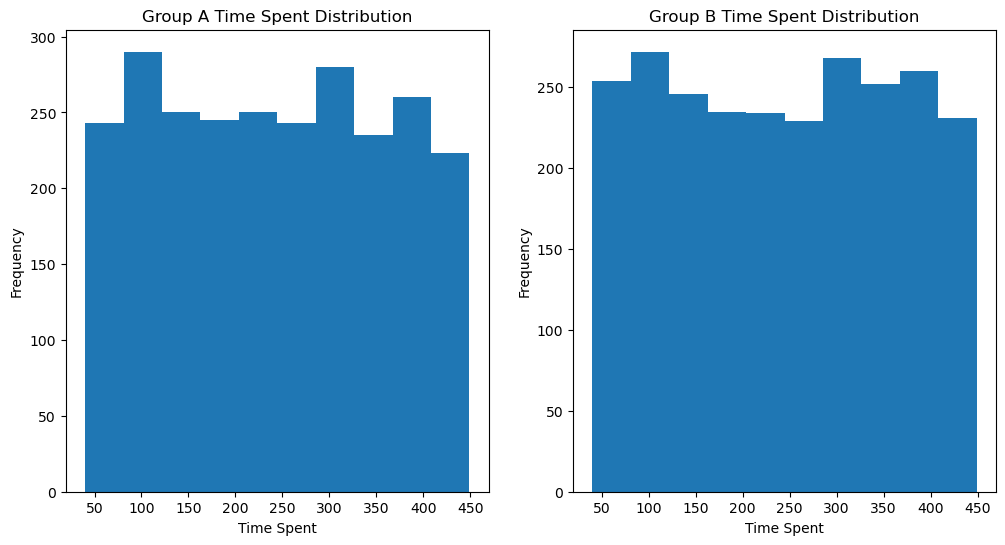

In [47]:
# 3. Visualising the distribution of time spent for both groups
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(group_a['Time Spent'])
plt.title('Group A Time Spent Distribution')
plt.xlabel('Time Spent')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(group_b['Time Spent'])
plt.title('Group B Time Spent Distribution')
plt.xlabel('Time Spent')
plt.ylabel('Frequency')
plt.show()

# Like with pageviews the distribution is not normal. So will have to check the sampling distribution of the means.

In [48]:
# Creating empty lists to store the sample means
group_a_time_spent_sample_means = []
group_b_time_spent_sample_means = []

# Creating a random sample of time spent from both group a and group b. Then calculating the mean and adding it to the list.
for _ in range(num_samples):
    sample = np.random.choice(group_a['Time Spent'], size=sample_size, replace=True)
    sample_mean = np.mean(sample)
    group_a_time_spent_sample_means.append(sample_mean)

for _ in range(num_samples):
    sample = np.random.choice(group_b['Time Spent'], size=sample_size, replace=True)
    sample_mean = np.mean(sample)
    group_b_time_spent_sample_means.append(sample_mean)

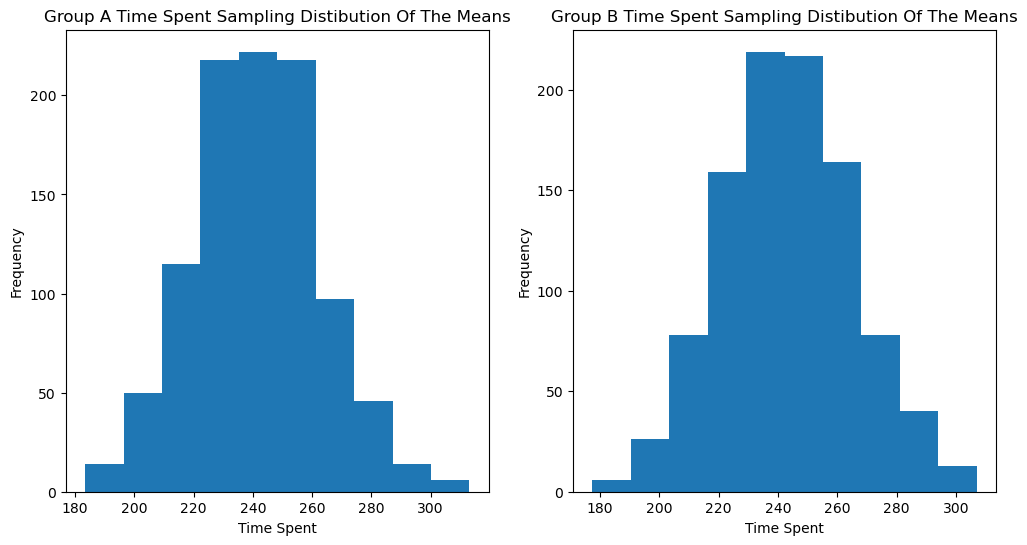

In [49]:
# Visualising the sampling distibution of the means for group a/b time spent
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(group_a_time_spent_sample_means)
plt.title('Group A Time Spent Sampling Distibution Of The Means')
plt.xlabel('Time Spent')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(group_b_time_spent_sample_means)
plt.title('Group B Time Spent Sampling Distibution Of The Means')
plt.xlabel('Time Spent')
plt.ylabel('Frequency')
plt.show()

- 4.Group A and Group B are independent from one another and a person from each one cannot influence another.

# Implementing Two Sample T-Test - Time Spent

In [50]:
# Running a two sample t-test for time spent
tstat_time, pval_time = ttest_ind(group_a['Time Spent'], group_b['Time Spent'], equal_var=False)
print(tstat_time)
print(pval_time)

if pval_time < 0.05:
    print("Significant difference in time spent on the website between groups.")
else:
    print("No significant difference in time spent on the website.")

-0.4694926489675219
0.6387380383087231
No significant difference in time spent on the website.


# Effect Size - Time Spent

In [51]:
# Compute Cohen's d - effect size of time spent groups
effect_size_time_spent = abs(cohen_d(df[df['Group']=='A']['Time Spent'] , df[df['Group']=='B']['Time Spent']))
print(f"Cohen's d effect size: {effect_size_time_spent:.4f}")

Cohen's d effect size: 0.0133


- Just like the page views test the effect size is so low that even if a significant difference was found the difference between the groups is so minimal and not very meaningful.

# Actual Power - Time Spent

In [52]:
# Compute actual power with group a sample size
actual_power_time_spent = analysis.power(effect_size_time_spent, nobs1=samples_A, alpha=0.05)
print(f"Actual power of the test: {actual_power_time_spent:.4f}")

Actual power of the test: 0.0758


- Also like the page views test the actual power of the test is poor due to the lack of samples.

# Chi-Squared Test - Device Conversion - Desktop

- Null Hypothesis: There is no association between group assignment (A/B) and conversion rate among desktop users.
- Alternative Hypothesis: There is an association between group assignment and conversion rate among desktop users.
- Significance Threshold: 0.05

# Checking Chi-Squared Test Assumptions

- 1.The dataset is created from random synthetic samples. Therefore each person is independent and has no influence on another persons decision to convert or not.
- 2.The categories of both variables are mutually exclusive. Each desktop user is only part of one group and only has one value in the conversion column. (yes or no)
- 3.Each sample in the test has their own unique user id. After checking for any duplicates none were found, meaning all rows are distinct.

# Chi-Squared Test - Desktop - Sample Size

In [53]:
# Creating two dfs for each different device user
df_desktop = df[df['Device']=='Desktop']
df_mobile = df[df['Device']=='Mobile']

In [54]:
# Getting the number of samples for each group from the desktop and mobile users
desktop_sample_size = df_desktop.groupby('Group')['Conversion'].count()
mobile_sample_size = df_mobile.groupby('Group')['Conversion'].count()

desktop_samples_a = desktop_sample_size['A']
desktop_samples_b = desktop_sample_size['B']

mobile_samples_a = mobile_sample_size['A']
mobile_samples_b = mobile_sample_size['B']

In [55]:
# Define parameters
alpha = 0.05  # Significance level (5%)
power = 0.8   # Desired power (80%)
effect_size_desktop = proportion_effectsize(df_desktop[df_desktop['Group']=='A']['Conversion'].mean(),
                                   df_desktop[df_desktop['Group']=='B']['Conversion'].mean())

In [56]:
# Calculate required sample size per group
sample_size_desktop = analysis.solve_power(effect_size_desktop, power=power, alpha=alpha, 
                                           ratio=desktop_samples_a/desktop_samples_b, alternative='two-sided')

print(f"Required sample size per group: {int(np.ceil(sample_size_desktop))}")

Required sample size per group: 213


# Implementing Chi-Squared Test - Device Conversion - Desktop

In [57]:
# Getting the conversion rates for people who used each different device from each group
device_conversion = df.groupby(['Device', 'Group'])['Conversion'].mean().unstack()
device_conversion

Group,A,B
Device,,
Desktop,0.058682,0.139104
Mobile,0.049412,0.142376


In [58]:
# Creating a crosstab for the counts of desktop users split by group and conversion
table_desktop = pd.crosstab(df_desktop.Group, df_desktop.Conversion) 
table_desktop

Conversion,0,1
Group,,
A,1171,73
B,1114,180


In [59]:
# Running a chi squared test - desktop
chi2, pval_desktop, dof, expected = chi2_contingency(table_desktop)
print(chi2)
print(pval_desktop)

if pval_desktop < 0.05:
    print("Significant difference in conversion rate between groups of desktop users.")
else:
    print("No significant difference in conversion rate bewteen groups of desktop users.")

44.815862058862145
2.1646203776784772e-11
Significant difference in conversion rate between groups of desktop users.


# Effect Size - Device Conversion - Desktop

In [60]:
# Using the conversion rates of both groups in the function to calculate the effect size
effect_size_desktop = abs(cohen_h(df_desktop[df_desktop['Group']=='A']['Conversion'].mean(), 
                                  df_desktop[df_desktop['Group']=='B']['Conversion'].mean()))
print(f"Cohen's h: {effect_size_desktop:.4f}")

Cohen's h: 0.2751


# Actual Power - Device Conversion - Desktop

In [61]:
# Computing the actual power of the chi squared desktop test
actual_power_desktop = analysis.power(effect_size_desktop, nobs1=desktop_sample_size['A'], alpha=0.05)
print(f"Actual power of the test: {actual_power_desktop:.4f}")

Actual power of the test: 1.0000


# Chi-Squared Test - Device Conversion - Mobile

- Null Hypothesis: There is no association between group assignment (A/B) and conversion rate among mobile users.
- Alternative Hypothesis: There is an association between group assignment and conversion rate among mobile users.
- Significance threshold: 0.05

# Checking Chi-Squared Test Assumptions

- 1.The dataset is created from random synthetic samples. Therefore each person is independent and has no influence on another persons decision to convert or not.
- 2.The categories of both variables are mutually exclusive. Each mobile user is only part of one group and only has one value in the conversion column. (yes or no)
- 3.Each sample in the test has their own unique user id. After checking for any duplicates none were found, meaning all rows are distinct.

# Chi-Squared Test - Mobile - Sample Size

In [62]:
# Calculate the effect size based on the two continuous groups
effect_size_mobile = proportion_effectsize(df_mobile[df_mobile['Group']=='A']['Conversion'].mean(),
                                   df_mobile[df_mobile['Group']=='B']['Conversion'].mean())

In [63]:
# Calculate required sample size per group
sample_size_mobile = analysis.solve_power(effect_size_mobile, power=power, alpha=alpha,
                                          ratio=mobile_samples_a/mobile_samples_b, alternative='two-sided')

print(f"Required sample size per group: {int(np.ceil(sample_size_mobile))}")

Required sample size per group: 144


# Implementing Chi-Squared Test - Device Conversion - Mobile

In [64]:
# Creating a crosstab for the counts of mobile users split by group and conversion
table_mobile = pd.crosstab(df_mobile.Group, df_mobile.Conversion) 
table_mobile

Conversion,0,1
Group,,
A,1212,63
B,1018,169


In [65]:
# Running a chi squared test - mobile
chi2, pval_mobile, dof, expected = chi2_contingency(table_mobile)
print(chi2)
print(pval_mobile)

if pval_mobile < 0.05:
    print("Significant difference in conversion rate between groups of mobile users.")
else:
    print("No significant difference in conversion rate bewteen groups of mobile users.")

61.157863200942984
5.267695995029192e-15
Significant difference in conversion rate between groups of mobile users.


# Effect Size - Device Conversion - Mobile

In [66]:
# Using the conversion rates of both groups in the function to calculate effect size
effect_size_mobile = abs(cohen_h(df_mobile[df_mobile['Group']=='A']['Conversion'].mean(), 
                                  df_mobile[df_mobile['Group']=='B']['Conversion'].mean()))
print(f"Cohen's h: {effect_size_mobile:.4f}")

Cohen's h: 0.3255


# Actual Power - Device Conversion - Mobile

In [67]:
# Compute actual power of the chi squared mobile test
actual_power_mobile = analysis.power(effect_size_mobile, nobs1=mobile_sample_size['A'], alpha=0.05)
print(f"Actual power of the test: {actual_power_mobile:.4f}")

Actual power of the test: 1.0000
